In [1]:
from typing import Callable, Iterable, List, Dict, Tuple, Any
from numbers import Number

import random
import re
from nltk.tokenize import TweetTokenizer

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

In [2]:
SEED = 32
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
LEARNING_RATE = 0.004
BATCH_SIZE = 64
EPOCHS = 175

LAYER_SIZES = [64, 32, 16]
USE_RELU = True
USE_DROPOUT = False

TRY_GPU = False

In [4]:
NUM_CLASSES = 3
CLASS_NAMES = ['Neutral', 'Anti-Vaccine', 'Pro-Vaccine']

In [5]:
TRAIN_SET_PATH = "./vaccine_train_set.csv"
VALIDATION_SET_PATH = "./vaccine_validation_set.csv"
EMBEDDINGS_PATH = '/mnt/c/Users/pavlo/Downloads/glove.6B.200d.txt'

In [6]:
wordVectors: Dict[str, np.ndarray] = {}
lineElements: List[str] = []
with open(EMBEDDINGS_PATH) as file:
    for line in file:
        lineElements = line.replace('\n', '').split()
        word = lineElements.pop(0)
        wordVector = np.array([float(w) for w in lineElements])
        wordVectors[word] = wordVector
dimensions = len(lineElements)

In [7]:
trainDF = pd.read_csv(TRAIN_SET_PATH)
trainDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [8]:
validDF = pd.read_csv(VALIDATION_SET_PATH)
validDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [9]:
features = trainDF.drop(['label', 'Unnamed: 0'], axis=1)
X_train = np.array([ar[0] for ar in features.values])
trainLabels = trainDF['label'].values

features = validDF.drop(['label', 'Unnamed: 0'], axis=1)
X_valid = np.array([ar[0] for ar in features.values])
validLabels = validDF['label'].values

In [10]:
def customPreprocessor(text: str):    
    # remove url's
    trimmedText = re.sub(r'https?://\S+|www\.\S+|#', '', text).lower()

    # remove @ mentions and numbers
    res = list()
    wait_whitespace = False
    for c in trimmedText:
        if wait_whitespace:
            if c == " ":
                wait_whitespace = False
            continue
        elif re.match("[0-9]", c) or c == "@":
            wait_whitespace = True
            continue            
        res.append(c)
    
    return ''.join(res)

In [11]:
tokenizer = TweetTokenizer()
def vectorizeTweet(tweet: str, preprocessor: Callable[[str], str], wordVectors: Dict[str, np.ndarray], dimensions: int) -> np.ndarray:
    # words = preprocessor(tweet).split()
    words = tokenizer.tokenize(preprocessor(tweet))
    # words = tokenizer.tokenize(tweet)
    vector: np.ndarray = np.zeros(dimensions)
    for word in words:
        wordVector = wordVectors.get(word)
        if wordVector is not None:
            vector += wordVector        
    return vector / len(words)

def vectorizeDataSet(dataSet: Iterable[str], dimensions: int):
    matrix: np.ndarray = np.zeros(shape=(len(dataSet), dimensions))
    for i, sample in enumerate(dataSet):
        matrix[i] = vectorizeTweet(sample, customPreprocessor, wordVectors, dimensions)
    
    return matrix

In [12]:
trainSet_X: np.ndarray = vectorizeDataSet(X_train, dimensions)
validSet_X: np.ndarray = vectorizeDataSet(X_valid, dimensions)

In [13]:
class Network(nn.Module):
    def __init__(self, n_features: int, hidden_sizes: Iterable[int], n_classes: int) -> None:
        super(Network, self).__init__()
        
        self.layers = nn.ModuleList()
        n_in = n_features
        for size in hidden_sizes:
            self.layers.append(nn.Linear(n_in, size))
            n_in = size
        self.layerOut = nn.Linear(n_in, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
    
    def forward(self, input):
        last_out = input
        for layer in self.layers:
            last_out = layer(last_out)
            if USE_RELU:
                last_out = self.relu(last_out)
            if USE_DROPOUT:
                last_out = self.dropout(last_out)
        
        return self.layerOut(last_out)


In [14]:
network = Network(dimensions, LAYER_SIZES, NUM_CLASSES)
network.layers

ModuleList(
  (0): Linear(in_features=200, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=32, bias=True)
  (2): Linear(in_features=32, out_features=16, bias=True)
)

In [15]:
def createClassWeights(sampleLabels, numClasses):
    classCounts = [0 for _ in range(numClasses)]
    for label in sampleLabels:
        classCounts[label] += 1

    weights = []
    for count in classCounts:
        rate = len(sampleLabels)/count
        weights.append(rate*rate)
    
    return weights

In [16]:
def plotConfusionMatrix(trueLabels: Iterable[int], predictions:Iterable[int], title: str, displayLabels: Iterable[str]=None, axes: plt.Axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(6,5))
    disp = ConfusionMatrixDisplay.from_predictions(trueLabels, predictions, cmap=plt.cm.Reds, ax=axes, colorbar=False)
    if displayLabels is not None:
        disp.ax_.set_xticklabels(displayLabels)
        disp.ax_.set_yticklabels(displayLabels)
    axes.set_xlabel('Classifier predicted labels', fontsize=11)
    axes.set_ylabel('True labels', fontsize=11)
    axes.set_title(title, fontsize=14)

In [17]:
y = torch.tensor(trainLabels, dtype=torch.float)
x = torch.tensor(trainSet_X, dtype=torch.float)

dataset = TensorDataset(x, y)
trainSetLoader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

Y_validTensor = torch.tensor(validLabels, dtype=torch.float)
X_validTensor = torch.tensor(validSet_X, dtype=torch.float)

weights = createClassWeights(trainLabels, NUM_CLASSES)
sampler = WeightedRandomSampler(weights, len(trainLabels))
dataset = TensorDataset(X_validTensor, Y_validTensor)
validSetLoader = DataLoader(dataset, batch_size=BATCH_SIZE)

lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=LEARNING_RATE)

In [18]:
if TRY_GPU:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    network.to(device)

In [19]:
def getPredictedLabels(predictions: torch.Tensor) -> np.ndarray:
    softmaxLayerOut = torch.log_softmax(predictions, dim = 1)
    _, labels = torch.max(softmaxLayerOut, dim = 1)
    return labels.detach().numpy()

In [20]:
def calculateAccuracy(predictedLabels: Iterable[Number], trueLabels: Iterable[Number]) -> float:    
    correct = 0
    for pred, true in zip(predictedLabels, trueLabels):
        correct += int(pred == true)
    
    return correct/len(trueLabels)*100

In [21]:
validPredictions: np.ndarray = np.empty(EPOCHS, dtype=np.ndarray)
validErrors: List[Number] = []
trainErrors: List[Number] = []
for epoch in range(EPOCHS):
    network.train()
    batchLosses = []
    batchAccs = []

    for batchSamples, batchLabels in trainSetLoader:

        if TRY_GPU:
            batchSamples = batchSamples.to(device)
            batchLabels = batchLabels.to(device)
        
        predictions = network(batchSamples)

        batchLoss = lossFunction(predictions, batchLabels.long())
        batchLosses.append(batchLoss.item())

        batchAccs.append(calculateAccuracy(getPredictedLabels(predictions), batchLabels))        

        optimizer.zero_grad()

        batchLoss.backward()

        optimizer.step()
    
    trainErrors.append(sum(batchLosses)/len(batchLosses))
    
    network.eval()
    with torch.no_grad():
        validOutput = network(X_validTensor)

        validLoss = lossFunction(validOutput, Y_validTensor.long())
        validErrors.append(validLoss.item())
        
        validEpochPredictions = getPredictedLabels(validOutput)
        validPredictions[epoch] = validEpochPredictions
        acc = calculateAccuracy(validEpochPredictions, validLabels)
    
    print(f"Epoch {epoch:3} Train Acc = {sum(batchAccs)/len(batchAccs):.5f} Valid Acc = {acc:.5f}\r", end='')
print()

Epoch 174 Train Acc = 69.91250 Valid Acc = 68.36109


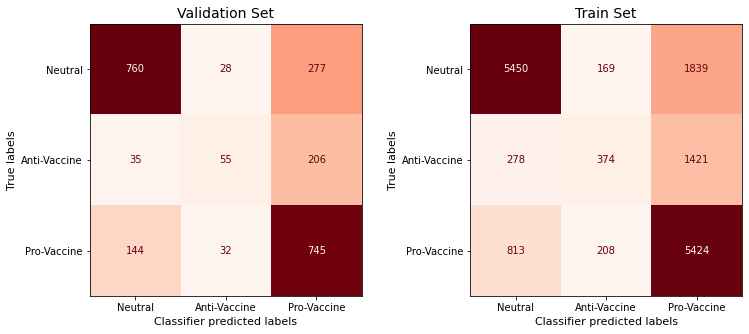

In [22]:
labels = ['Neutral', 'Anti-Vaccine', 'Pro-Vaccine']
_, ax = plt.subplots(1, 2, figsize=(12.5,5))
plotConfusionMatrix(Y_validTensor.int().detach().numpy(), validPredictions[-1], 'Validation Set', labels, ax[0])
x = torch.tensor(trainSet_X, dtype=torch.float)
pred = network(x)
plotConfusionMatrix(trainLabels, getPredictedLabels(pred), 'Train Set', labels, ax[1])

In [23]:
def calculateROCScores(trueLabels: Iterable[Number], predictedLabels: Iterable[Number], numClasses: int) -> Dict[int, Tuple[Number, Number]]:
    scores: Dict[int, Tuple[Number, Number]] = {}
    confMatrix = confusion_matrix(trueLabels, predictedLabels)
    for c in range(numClasses):
        tn = 0
        fp = 0
        fn = 0
        for i in range(len(confMatrix)):
            if c == i:
                for j in range(len(confMatrix[i])):
                    if i == j:
                        tp = confMatrix[i][j]
                    else:
                        fn += confMatrix[i][j]
            else:
                for j in range(len(confMatrix[i])):
                    if j == c:
                        fp += confMatrix[i][j]
                    else:
                        tn += confMatrix[i][j]
        fpRate = 0
        tpRate = 0
        if fp + tn > 0:
            fpRate = fp/(fp + tn)
        if tp + fn > 0:
            tpRate = tp/(tp + fn)
        scores[c] = (tpRate, fpRate)
    
    return scores

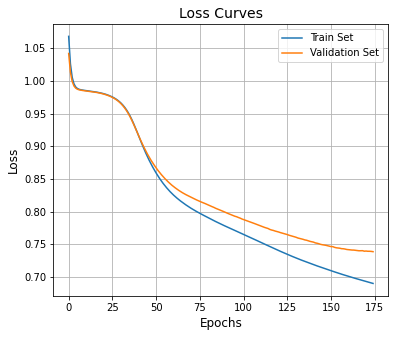

In [24]:
def plotLossCurves(trainLosses: Iterable[Number], validationLosses: Iterable[Number], axes: plt.Axes = None):

    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(6,5))
    
    axes.grid()
    axes.set_title("Loss Curves", fontsize=14)
    axes.set_xlabel('Epochs', fontsize=12)
    axes.set_ylabel('Loss', fontsize=12)
    
    epochs = [i for i in range(len(validationLosses))]

    axes.plot(epochs, trainLosses, label='Train Set')
    axes.plot(epochs, validationLosses, label='Validation Set')

    axes.legend(loc="best")
    plt.show()

# preds = validPredictions[np.round(np.linspace(0, len(validPredictions) - 1, 25)).astype(int)]
plotLossCurves(trainErrors, validErrors)

In [25]:
labels = np.zeros((len(validLabels), NUM_CLASSES), dtype=int)
for index, label in enumerate(validLabels):
    labels[index][label] = 1

#scores = np.zeros((len(validLabels), NUM_CLASSES), dtype=int)
scores = torch.softmax(validOutput, dim = 1).detach().numpy()
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], scores[:, i], drop_intermediate=True)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

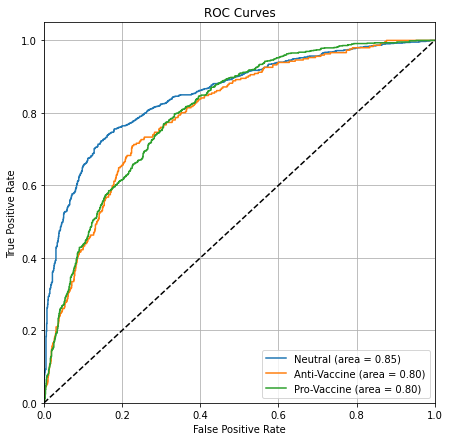

In [26]:
# Plot all ROC curves
plt.figure(figsize=(7,7))
plt.grid()

for i in range(NUM_CLASSES):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"{CLASS_NAMES[i]} (area = {roc_auc[i]:0.2f})"
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()